In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd

DATA_PATH = "/content/drive/MyDrive/processed_milestone2_dataset.xlsx"

df = pd.read_excel(DATA_PATH)
print("Dataset Loaded Successfully!")
df.head()


Dataset Loaded Successfully!


,order_id,supplier_id,supplier_rating,supplier_lead_time,order_date,promised_delivery_date,actual_delivery_date,shipping_distance_km,order_quantity,unit_price,...,region_South,region_West,holiday_period_Yes,carrier_name_DHL,carrier_name_Delhivery,carrier_name_EcomExpress,carrier_name_FedEx,delayed_reason_code_Operational,delayed_reason_code_Traffic,delayed_reason_code_Weather
0,1.0,5322.0,3.4,10,2024-05-15,2024-05-25,2024-05-29,51,48,2153.91,...,False,False,False,False,False,True,False,True,False,False
1,2.0,3932.0,4.3,10,2024-11-12,2024-11-22,2024-11-27,373,91,405.36,...,False,False,True,True,False,False,False,False,False,False
2,3.0,8966.0,3.2,5,2024-08-28,2024-09-02,2024-09-02,1304,25,3241.41,...,True,False,False,False,False,False,False,False,False,False
3,4.0,9832.0,3.9,7,2024-08-12,2024-08-19,2024-08-19,839,71,365.79,...,False,False,False,False,False,False,True,True,False,False
4,5.0,2126.0,3.2,8,2024-07-07,2024-07-15,2024-07-18,258,9,3052.84,...,False,False,False,False,False,False,False,False,False,False


In [3]:
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10019 entries, 0 to 10018
Data columns (total 36 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   order_id                         10019 non-null  float64       
 1   supplier_id                      10019 non-null  float64       
 2   supplier_rating                  10019 non-null  float64       
 3   supplier_lead_time               10019 non-null  int64         
 4   order_date                       10019 non-null  datetime64[ns]
 5   promised_delivery_date           10019 non-null  datetime64[ns]
 6   actual_delivery_date             10019 non-null  datetime64[ns]
 7   shipping_distance_km             10019 non-null  int64         
 8   order_quantity                   10019 non-null  int64         
 9   unit_price                       10019 non-null  float64       
 10  total_order_value                10019 non-null  float64  

,order_id,supplier_id,supplier_rating,supplier_lead_time,order_date,promised_delivery_date,actual_delivery_date,shipping_distance_km,order_quantity,unit_price,...,region_South,region_West,holiday_period_Yes,carrier_name_DHL,carrier_name_Delhivery,carrier_name_EcomExpress,carrier_name_FedEx,delayed_reason_code_Operational,delayed_reason_code_Traffic,delayed_reason_code_Weather
0,1.0,5322.0,3.4,10,2024-05-15,2024-05-25,2024-05-29,51,48,2153.91,...,False,False,False,False,False,True,False,True,False,False
1,2.0,3932.0,4.3,10,2024-11-12,2024-11-22,2024-11-27,373,91,405.36,...,False,False,True,True,False,False,False,False,False,False
2,3.0,8966.0,3.2,5,2024-08-28,2024-09-02,2024-09-02,1304,25,3241.41,...,True,False,False,False,False,False,False,False,False,False
3,4.0,9832.0,3.9,7,2024-08-12,2024-08-19,2024-08-19,839,71,365.79,...,False,False,False,False,False,False,True,True,False,False
4,5.0,2126.0,3.2,8,2024-07-07,2024-07-15,2024-07-18,258,9,3052.84,...,False,False,False,False,False,False,False,False,False,False


In [16]:
# Fix target column: force binary
df["on_time_delivery"] = df["on_time_delivery"].apply(lambda x: 1 if x >= 1 else 0)
df["on_time_delivery"] = df["on_time_delivery"].astype(int)

print(df["on_time_delivery"].value_counts())


on_time_delivery
0    7137
1    2882
Name: count, dtype: int64


In [17]:
date_cols = [col for col in df.columns if "date" in col.lower()]

print("Date columns found:", date_cols)

df = df.drop(columns=date_cols, errors="ignore")


Date columns found: []


In [18]:
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
print("Categorical columns:", cat_cols)

df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
print("After encoding:", df.shape)


Categorical columns: []
After encoding: (10019, 33)


In [19]:
X = df.drop("on_time_delivery", axis=1)
y = df["on_time_delivery"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((8015, 32), (2004, 32))

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
scoring = "f1"


In [24]:
models = {
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=2000),
        "params": {
            "C": [0.01, 0.1, 1, 10],
            "penalty": ["l2"],
            "solver": ["lbfgs"],
        },
    },

    "RandomForest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
        },
    },

    "XGBoost": {
        "model": XGBClassifier(eval_metric="logloss", use_label_encoder=False),
        "params": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.1],
            "max_depth": [3, 6],
        },
    },
}


In [25]:
best_models = {}

for name, mp in models.items():
    print(f"\n🔵 Running GridSearch for {name}...")

    grid = GridSearchCV(
        estimator=mp["model"],
        param_grid=mp["params"],
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train)

    best_models[name] = grid.best_estimator_

    print("Best params:", grid.best_params_)
    print("Best F1 score:", grid.best_score_)



🔵 Running GridSearch for LogisticRegression...
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Best F1 score: 0.7201846823123429

🔵 Running GridSearch for RandomForest...
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Best params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best F1 score: 0.9222194940995461

🔵 Running GridSearch for XGBoost...
Fitting 4 folds for each of 8 candidates, totalling 32 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:59:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}
Best F1 score: 0.9569270540561996


In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

results = []

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob)
    })

pd.DataFrame(results)


,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,LogisticRegression,0.845808,0.766467,0.666667,0.713092,0.908227
1,RandomForest,0.961577,0.961183,0.902778,0.931065,0.975415
2,XGBoost,0.979541,0.987250,0.940972,0.963556,0.978649


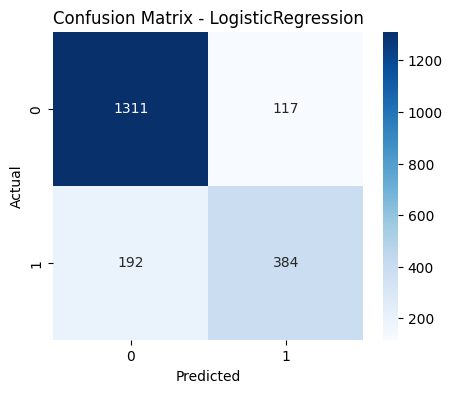

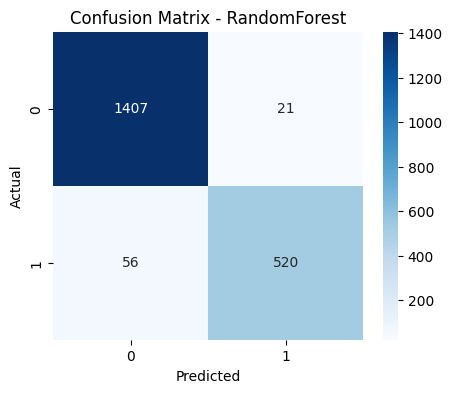

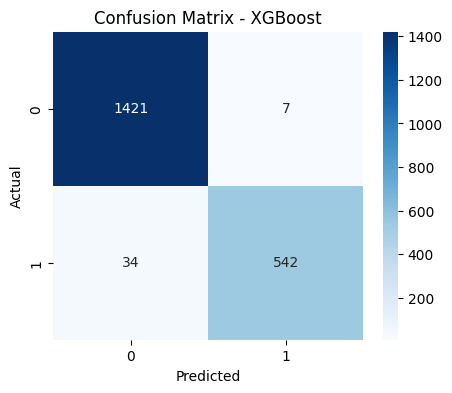

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
